This notebook is a low-quality solution for the digits competition on Kaggle. See if you can improve it! The metric by which the quality of solutions is judged is classification accuracy(% of images that are correctly classified.)

First, import packages and read in the data.

In [51]:
import pandas as pd # for reading/manipulating/viewing data
from sklearn.metrics import accuracy_score # for evaluating model
import matplotlib.pyplot as plt # for displaying images and plots
import re # for interpreting, comparing and manipulating strings using regular expressions
import numpy as np # for doing mathematical operations

In [2]:
train = pd.read_csv("../data/digit-recognizer/train.csv")
test = pd.read_csv("../data/digit-recognizer/test.csv")

Now, see what the data look like!

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [8]:
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

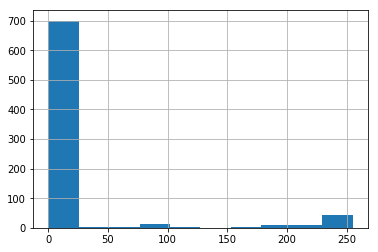

In [12]:
train.loc[0].drop('label').hist()

In [35]:
train.drop(columns=['label']).max().max()

255

In [36]:
train.drop(columns=['label']).min().min()

0

So we can see that the training data set comprises 42,000 images, each of which has 784 (=28x28) pixel values between 0 and 255 (grayscale images), and each of which has a label indicating the ground truth, or gold standard, which is a label assigned by a human to specify which digit from 0 to 9 the image represents. Let's visualise a few of them, so you get the idea.

*****************************************


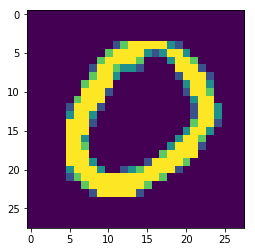

Label says  0
*****************************************




*****************************************


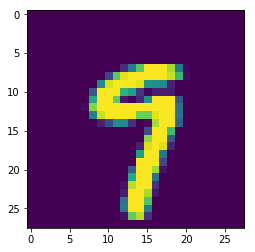

Label says  9
*****************************************




*****************************************


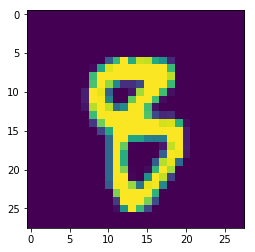

Label says  8
*****************************************




*****************************************


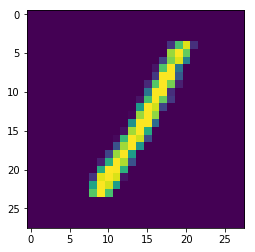

Label says  1
*****************************************




*****************************************


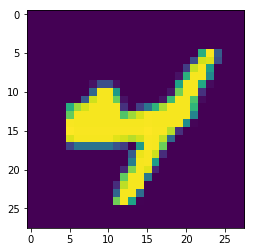

Label says  4
*****************************************




*****************************************


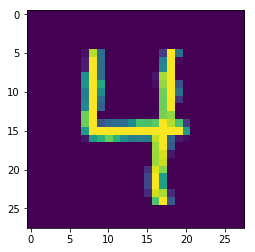

Label says  4
*****************************************




*****************************************


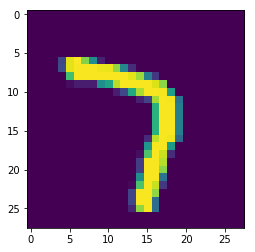

Label says  7
*****************************************




*****************************************


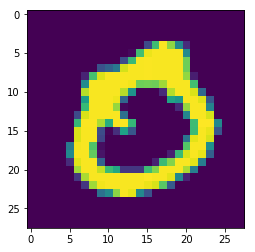

Label says  0
*****************************************




*****************************************


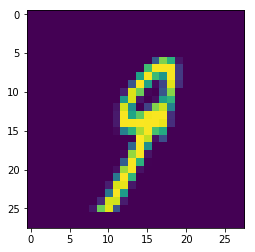

Label says  9
*****************************************




*****************************************


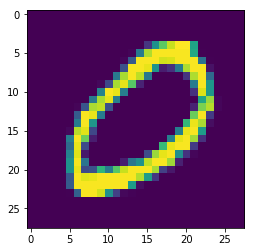

Label says  0
*****************************************






In [32]:
for n in range(10):
    print("*****************************************")
    sample = train.sample(1)
    plt.imshow(sample.drop('label', axis=1).values.reshape(28, 28))
    plt.show()
    print("Label says ", sample.label.values[0])
    print("*****************************************\n\n\n\n")

Now, let's try to build a classifier to determine which digit each image represents. The state of the art technique for this kind of problem is a type of deep learning model called a Convolutional Neural Network. But for the purposes of this demo, I want a simpler model. Let's try dividing the image into a number of grids, counting the proportion of 'bright' pixels in each grid, and then using those proportions as the variables for a classification algorithm. First, we need to transform the data to get the new features we discussed. Start out by writing a function to 'pad' each image with dark pixels (value 0) so that the new image has side length that is an integer multiple of the number of grids to a side.

In [62]:
def pad_image_data(image_data, grid_side_length):
    # First, figure out the smallest multiple of grid_side_length that is >= 28.
    augmented_grid_side_length = grid_side_length*int(np.ceil(28.0/grid_side_length))
    
    # Next, create a square matrix of zeros, whose size is given by the number we just calculated.
    padded_data = np.zeros((augmented_grid_side_length, augmented_grid_side_length))
    
    # Next, reshape the image data, which is a single array (or pandas Series), into a 28x28 matrix.
    reshaped_image_data = image_data.values.reshape(28, 28)
    
    # Now, assign the image data to the top-left 28x28 corner of the matrix of zeros.
    padded_data[0:28, 0:28] = reshaped_image_data
    
    return padded_data

Let's visualise what this function does with before-and-after pictures. I'll take a 28x28 image and pad it out with zeros so that the result will conveniently fit into a grid whose squares are each 9 pixels x 9 pixels in size.

Before


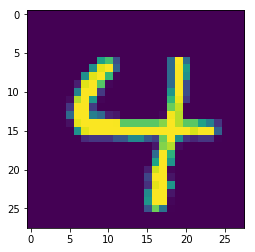

After


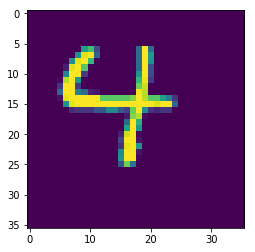

In [67]:
sample = test.sample(1)
reshaped_sample = sample.values.reshape(28, 28)
print("Before")
plt.imshow(reshaped_sample)
plt.show()
print("After")
padded_sample = pad_image_data(sample, 9)
plt.imshow(padded_sample)
plt.show()

So you can see that this code took the original 28x28 image and blew it up into a 36x36 image by adding dark pixels to the right and the bottom, because 36 is the smallest multiple of 9 that's greater than 28.

The next thing to do is to write a function that takes the padded image data, and spits out the array indices for an individual grid.

In [111]:
# This function calculates and returns the indices of the padded image data corresponding to a given
# grid number. The grid on the top left corner is number 0, and then they go sequentially from left to right,
# and from top to bottom.
def get_grid_idxs(padded_data_side_length, grid_side_length, grid_num):

    num_grid_squares_per_side = int(np.ceil(padded_data_side_length/grid_side_length))
    
    grid_col_num = np.mod(grid_num, num_grid_squares_per_side)
    grid_row_num = np.floor(grid_num/num_grid_squares_per_side)
    
    col_start_idx = int(grid_side_length*grid_col_num)
    col_end_idx = int(grid_side_length*(grid_col_num + 1))
    
    row_start_idx = int(grid_side_length*grid_row_num)
    row_end_idx = int(grid_side_length*(grid_row_num + 1))

    return {'row_idxs': (row_start_idx, row_end_idx), 'col_idxs': (col_start_idx, col_end_idx)}

As an example of what this function does, see below.

In [123]:
# This function was copied from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1.
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()*0.15) * n_images)
    plt.show()

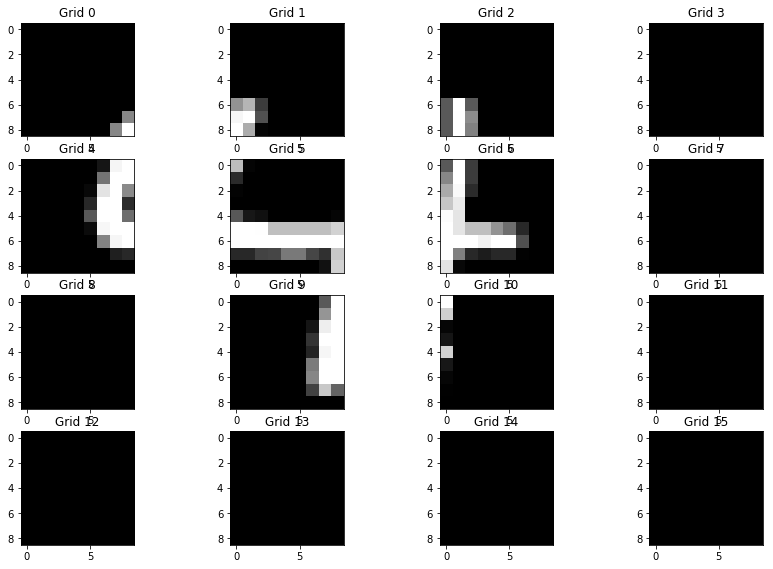

In [124]:
# Here is the code plotting the images.
images = []
titles = []
num_grids = 4**2
for g_num in range(num_grids):
    idxs=get_grid_idxs(padded_sample.shape[0], 9, g_num)
    images.append(padded_sample[idxs['row_idxs'][0]:idxs['row_idxs'][1], idxs['col_idxs'][0]:idxs['col_idxs'][1]])
    titles.append("Grid " + str(g_num))

show_images(images, cols = 4, titles = titles)

Okay! Now let's write a function to compute the number of bright pixels in a grid.

In [125]:
def count_bright_pixels(grid_data, bright_threshold = 0):
    return (grid_data > bright_threshold).sum()

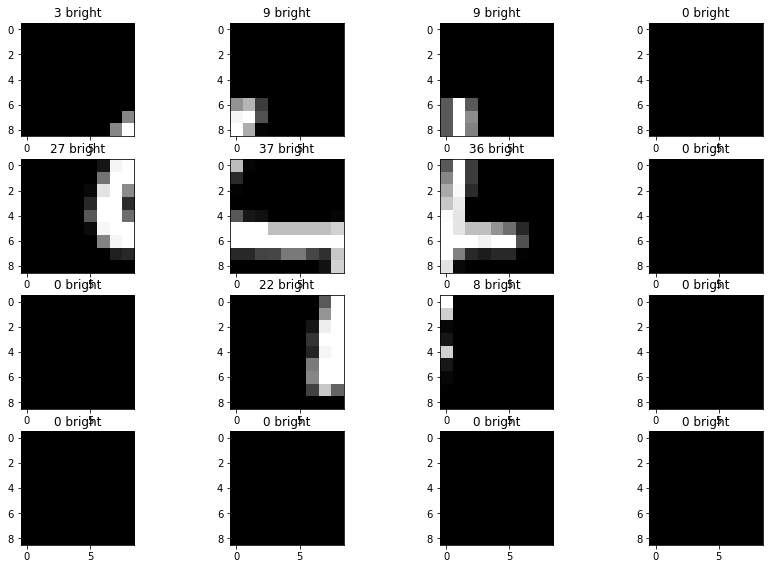

In [128]:
# Here is the code plotting the images.
images = []
titles = []
num_grids = 4**2
for g_num in range(num_grids):
    idxs=get_grid_idxs(padded_sample.shape[0], 9, g_num)
    images.append(padded_sample[idxs['row_idxs'][0]:idxs['row_idxs'][1], idxs['col_idxs'][0]:idxs['col_idxs'][1]])
    titles.append("%d bright" % count_bright_pixels(images[-1]))

show_images(images, cols = 4, titles = titles)

Now we've got all the pieces to convert each image into a list of bright pixel counts per grid. We will use those counts as the input to our model.

In [149]:
def convert_row_to_new_features(row, grid_side_length):
    padded_data = pad_image_data(row, grid_side_length)
    padded_data_side_length = padded_data.shape[0]
    num_squares_per_side = int(padded_data_side_length/grid_side_length)
    num_squares = num_squares_per_side ** 2
    new_features = {}
    for g_num in range(num_squares):
        idxs = get_grid_idxs(padded_data_side_length, grid_side_length, g_num)
        subimage = padded_data[idxs['row_idxs'][0]:idxs['row_idxs'][1], idxs['col_idxs'][0]:idxs['col_idxs'][1]]
        new_features[g_num] = count_bright_pixels(subimage)
    return new_features

Test out this function.

In [148]:
convert_row_to_new_features(test.sample(1), 6)

0      0
1      0
2     12
3      8
4      0
5      0
6     11
7     19
8      3
9      0
10     0
11    23
12    30
13     9
14     0
15     0
16    10
17    30
18    11
19     0
20     0
21     0
22     0
23     0
24     0
dtype: int64

Great! Now we are ready to compute the new features for our images. Let's try a grid of side length 10, so it will be a 3x3 grid covering our 28x28 images (which will be padded to 30x30).

In [154]:
new_features_train=train.drop('label', axis=1).apply(lambda row: convert_row_to_new_features(row, 10), axis=1)
new_features_train.head()

0    {0: 0, 1: 15, 2: 12, 3: 4, 4: 48, 5: 0, 6: 11,...
1    {0: 16, 1: 56, 2: 6, 3: 52, 4: 30, 5: 34, 6: 8...
2    {0: 0, 1: 24, 2: 0, 3: 0, 4: 39, 5: 0, 6: 0, 7...
3    {0: 14, 1: 13, 2: 0, 3: 18, 4: 43, 5: 11, 6: 0...
4    {0: 17, 1: 56, 2: 7, 3: 50, 4: 21, 5: 48, 6: 1...
dtype: object

In [157]:
new_features_test=test.apply(lambda row: convert_row_to_new_features(row, 10), axis=1)
new_features_test.head()

0    {0: 3, 1: 55, 2: 9, 3: 28, 4: 61, 5: 32, 6: 12...
1    {0: 7, 1: 39, 2: 12, 3: 41, 4: 27, 5: 43, 6: 1...
2    {0: 0, 1: 24, 2: 6, 3: 4, 4: 54, 5: 1, 6: 5, 7...
3    {0: 0, 1: 26, 2: 1, 3: 19, 4: 52, 5: 5, 6: 2, ...
4    {0: 1, 1: 47, 2: 0, 3: 3, 4: 66, 5: 0, 6: 9, 7...
dtype: object